# 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 폴더 경로로 이동

In [ ]:
# 폴더 경로에 맞게 변경
%cd /content/drive/MyDrive/rhee/code/halibut

# requirements.txt

In [13]:
!pip install ultralytics
!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install numpy
!pip install pandas
!pip install Pillow
!pip install pyYAML
!pip install requests
!pip install tqdm
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 4.9 MB/s eta 0:00:00a 0:00:01


# convert coco to yolo

In [2]:
import os
import json

In [3]:
with open("../datasets/sample_dataset/train/_annotations.coco.json", "r") as train_json:
    train_dataset = json.load(train_json)
    train_json.close()

with open("../datasets/sample_dataset/valid/_annotations.coco.json", "r") as valid_json:
    valid_dataset = json.load(valid_json)
    valid_json.close()

with open("../datasets/sample_dataset/test/_annotations.coco.json", "r") as test_json:
    test_dataset = json.load(test_json)
    test_json.close()

In [4]:
def json2yolo(dataset, save_path):
    os.makedirs(save_path, exist_ok=True)

    categories = [category["name"] for category in dataset["categories"]]
    save_categories_name = os.path.join(save_path, "classes.txt")
    lines = ""
    for category in categories:
        lines += f"{category}\n"
    
    with open(save_categories_name, "w") as f:
        f.writelines(lines)
        f.close()

    for img, anno in zip(dataset["images"], dataset["annotations"]):
        lines = ""
        file_name = img["file_name"]
        save_name = os.path.join(save_path, file_name).replace(".jpg", ".txt")
        height = img["height"]
        width = img["width"]
        category = anno["category_id"]
        bbox = anno["bbox"]
        x1, y1, x2, y2 = bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]
        
        x = (x1+x2)/2/width
        y = (y1+y2)/2/height
        w = (x2-x1)/width
        h = (y2-y1)/height
        
        lines += f"{category} {round(x,6)} {round(y,6)} {round(w,6)} {round(h,6)}\n"
        
        with open(save_name, "w") as f:
            f.writelines(lines)
            f.close()

In [5]:
# # 넙치 메타 데이터는 라벨링이 잘 되어있어서 해당 함수는 사용하지 않음. coco json을 yolo txt로 변환할 필요 없음.
# json2yolo(train_dataset, "../datasets/sample_dataset/train/labels")
# json2yolo(valid_dataset, "../datasets/sample_dataset/valid/labels")
# json2yolo(test_dataset, "../datasets/sample_dataset/test/labels")

# train

In [11]:
from ultralytics import YOLO

In [13]:
"""
yolov8s 모델을 사용.
epoch 1000
batch size 16
patience 100
학습이 일정 수준으로 잘 학습이 되면 patience 파라미터를 통해서 100번 반복할 때까지 mAP에 향상이 없으면 학습을 중단시키는 것으로 학습 시간을 단축시킴.
hsv 변화, 크기, 플립, 모자이크의 augmentation 기법을 활용함.
"""
# build from YAML and transfer weights
model = YOLO('yolov8s.yaml').load('pretrained/yolov8s.pt')

# Train the model
model.train(cfg="cfg/custom.yaml")


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

# valid

In [14]:
"""
valid 데이터 셋에 있는 이미지로 검증을 할 수 있는 모델의 성능.
검증용 데이터 셋에 있는 클래스당 객체의 수(instances)에 따라 보이는 mAP가 달라짐.
한 자리 수 객체의 수를 가진 클래스는 한 자리 수 이상의 객체의 수를 가진 클래스 보다 성능이 안좋음.
일정 수준 이상 객체의 수를 가진 클래스는 준수한 성능을 보임을 알 수 있음.
"""
model.val()

Ultralytics YOLOv8.0.110 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (NVIDIA GeForce RTX 4090, 24215MiB)
YOLOv8m summary (fused): 218 layers, 25871026 parameters, 0 gradients
val: Scanning /media/int2/HardDisk1/datasets/AIHUB/halibut/4classes_fish_data/data/yolov8/valid/labels.cache... 168 images, 14 backgrounds, 0 corrupt: 100%|██████████| 168/168 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 255, len(boxes) = 286. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]
                   all        168        286      0.598      0.498      0.474      0.338
                 VIFAH        168          1          0          0      0.111     0.0111
                 VIFDH        168         12  

ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 2,  4,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7ff31c886760>
fitness: 0.3513073216542867
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.33773,     0.33773,    0.011056,     0.33773,    0.041232,     0.33773,     0.33773,           0,           0,     0.33773,     0.25717,     0.89355,     0.93944,      0.4785,      0.3852,     0.69099,     0.62897,     0.94448,     0.47336,     0.59322,     0.64796,     0.33773,    0.097316,     0.33773,
           0.33773,           0,     0.40275,           0,           0,           0,     0.58319,           0,           0,           0,      0.8955,     0

# predict

In [1]:
from ultralytics import YOLO
import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2

# 학습한 모델을 로드.
model = YOLO(model="runs/halibut/weights/best.pt", task="detect")
# model = YOLO(model="pretrained/yolov8s.pt", task="detect")

/home/int2/anaconda3/envs/rhee_halibut/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# 예측 결과에 클래스 이름을 넣기 위해 데이터 셋 내 클래스를 불러옴.
import yaml

with open('dataset/halibut.yaml') as f:
    dataset = yaml.load(f, Loader=yaml.FullLoader)
    f.close()

classes = dataset["names"]
print(classes)

{0: 'POOUN', 1: 'VIDYH', 2: 'VIFAH', 3: 'VIFCH', 4: 'VIFDH', 5: 'VIDYU', 6: 'POGCN', 7: 'SPDYH', 8: 'POKIN', 9: 'POASN', 10: 'POREN', 11: 'VISPE', 12: 'MAFAH', 13: 'MAFDH', 14: 'MAFCH', 15: 'MAOUY', 16: 'MAFDB', 17: 'MAFAB', 18: 'VIMOU', 19: 'VIOUY', 20: 'VIFAN', 21: 'VIGIP', 22: 'SPFCH', 23: 'SPOUY', 24: 'POGIN', 25: 'POLIN', 26: 'SPGCH', 27: 'SPASQ', 28: 'SPGIN', 29: 'SPLIC', 30: 'SPGIP', 31: 'POSPN', 32: 'POINN', 33: 'SPINI', 34: 'SPINH', 35: 'SPFAH', 36: 'VILIC', 37: 'VILII', 38: 'VIKIE', 39: 'SPFDH', 40: 'VIFDN', 41: 'SPEYH', 42: 'SPBEB', 43: 'MAMOU', 44: 'SPKIE', 45: 'MADYU', 46: 'MAGIP', 47: 'MAGIN', 48: 'VIFCN', 49: 'MAFCB', 50: 'SPSPE', 51: 'SPINT', 52: 'SPEYB', 53: 'MAFAL'}


In [26]:
# 예측된 클래스와 질병 코드에 맞는 설명을 볼 수 있도록 질병 코드별 증상 데이터를 불러옴.
import pandas as pd

df_details = pd.read_excel("../datasets/halibut/4classes_fish_data/class_code.xlsx", engine="openpyxl")
df_details = df_details.set_index(['코드'])
details = df_details.to_dict()['설명']
print(details)

{'POOUN': '정상 외형', 'VIDYH': '비브리오증 체표 출혈', 'VIFAH': '비브리오증 뒷 지느러미 출혈', 'VIFCH': '비브리오증 꼬리 지느러미 출혈', 'VIFDH': '비브리오증 등 지느러미 출혈', 'VIDYU': '비브리오증 체표 궤양', 'POGCN': '정상 아가미 뚜껑', 'SPDYH': '연쇄구균병 체표 출혈', 'POKIN': '정상 신장', 'POASN': '정상 복수', 'POREN': '정상 생식소', 'VISPE': '비브리오증 비장 비대', 'MAFAH': '스쿠티카병 뒷 지느러미 출혈', 'MAFDH': '스쿠티카병 등 지느러미 출혈', 'MAFCH': '스쿠티카병 꼬리 지느러미 출혈', 'MAOUY': '스쿠티카병 질병 외형', 'MAFDB': '스쿠티카병 등 지느러미 기부괴사', 'MAFAB': '스쿠티카병 뒷 지느러미 기부괴사', 'VIMOU': '비브리오증 주둥이 궤양', 'VIOUY': '비브리오증 질병 외형', 'VIFAN': '비브리오증 뒷 지느러미 괴사', 'VIGIP': '비브리오증 아가미 빈혈', 'SPFCH': '연쇄구균병 꼬리 지느러미 출혈', 'SPOUY': '연쇄구균병 질병 외형', 'POGIN': '정상 아가미', 'POLIN': '정상 간', 'SPGCH': '연쇄구균병 아가미뚜껑 안쪽 염증', 'SPASQ': '연쇄구균병 탁한 복수', 'SPGIN': '연쇄구균병 아가미 괴사', 'SPLIC': '연쇄구균병 간 울혈', 'SPGIP': '연쇄구균병 아가미 빈혈', 'POSPN': '정상 비장', 'POINN': '정상 장', 'SPINI': '연쇄구균병 장 염증', 'SPINH': '연쇄구균병 장 출혈', 'SPFAH': '연쇄구균병 뒷 지느러미 출혈', 'VILIC': '비브리오증 간 울혈', 'VILII': '비브리오증 간 염증', 'VIKIE': '비브리오증 신장 비대', 'SPFDH': '연쇄구균병 등 지느러미 출혈', 'VIFDN': '비브리오증 등 지느러미 괴사', '

In [35]:
def predict(
    im_path="img path",
    im_show=True,
    classes=None,
    details=None,
):
    """
    예측 코드, 
    verbose=False -> yolov8 output을 무시,
    iou=0.75 -> predict 교집합 ground_truth / predict 합집합 ground_truth 를 0.75 수준으로 진행
    device=0 -> 0번째 gpu를 사용하겠다는 것 없으면 cpu로 진행
    """
    outputs = []
    img = cv2.imread(im_path, cv2.IMREAD_COLOR)
    results = model.predict(source=img, verbose=False, iou=0.75, device=0)  # predict on an image
    for result in results:
        score = result.boxes.conf.cpu().numpy()  # 객체 당 score tensor 리스트
        class_id = result.boxes.cls.cpu().numpy()  # 객체 당 class 리스트
        xyxy = result.boxes.xyxy.cpu().numpy()  # 객체 당 xyxy 리스트

        for i in range(len(class_id)):
            if score[i] >= 0.7: # confidence score가 0.7 이상인 것만 detection
                x1, y1, x2, y2 = [int(x) for x in xyxy[i]] # x1, y1, x2, y2 좌표 추출
                # input bounding box
                img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 3)
                # input text
                img = cv2.putText(img, str(classes[class_id[i]]), (x1+10, y1+30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)
                output = {
                    'im_path' : im_path,
                    'code' : str(classes[class_id[i]]),
                    'xyxy' : (x1, y1, x2, y2),
                    'details' : str(details[classes[class_id[i]]]),
                }
                outputs.append(output)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if im_show:
        plt.imshow(img)
        plt.show()
    
    return outputs

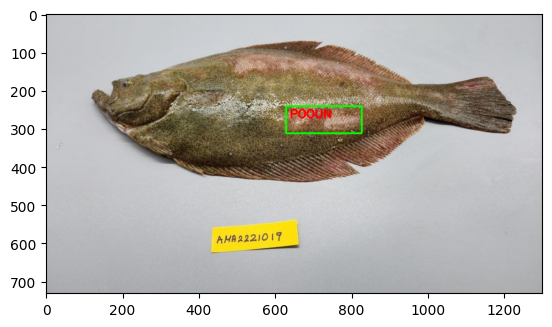

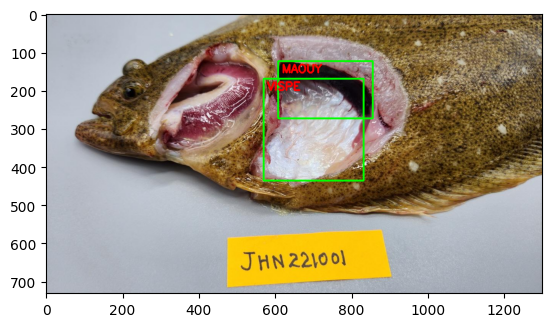

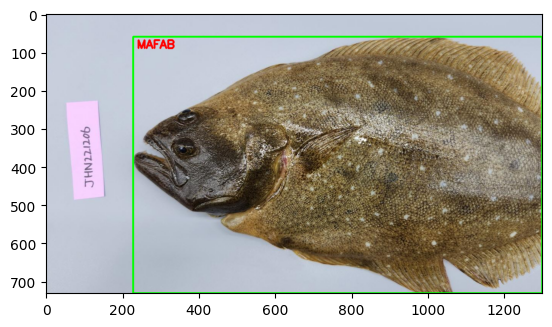

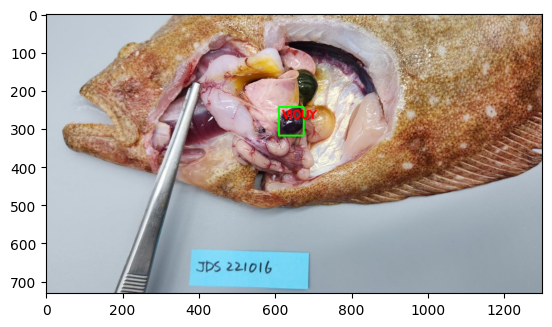

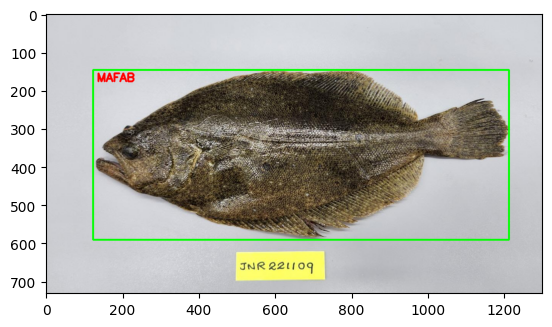

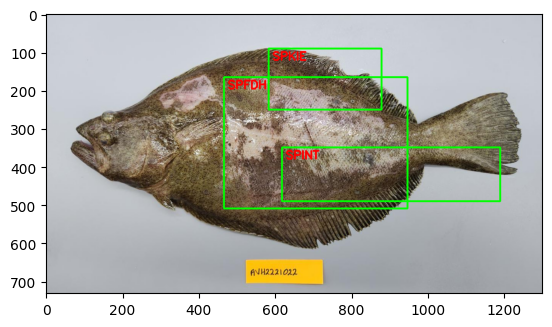

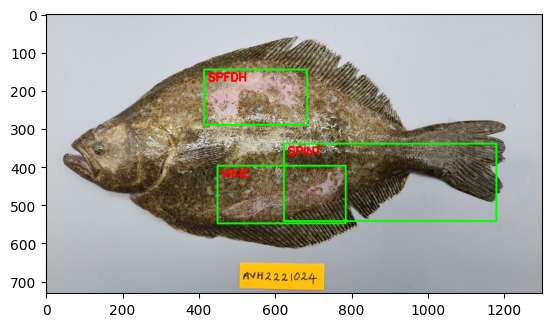

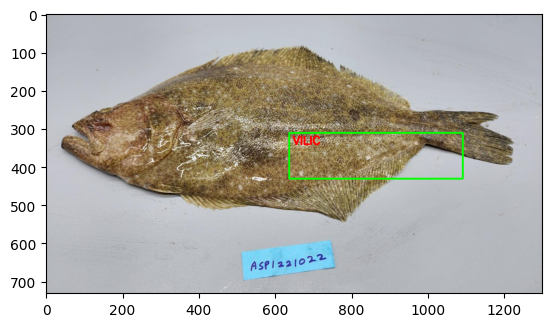

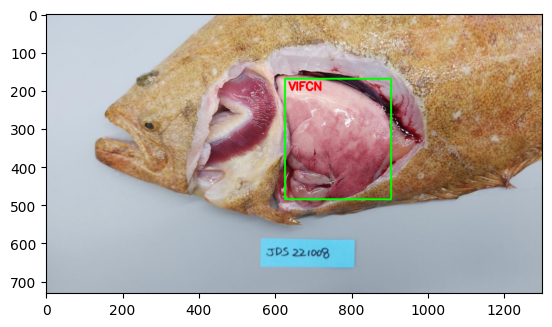

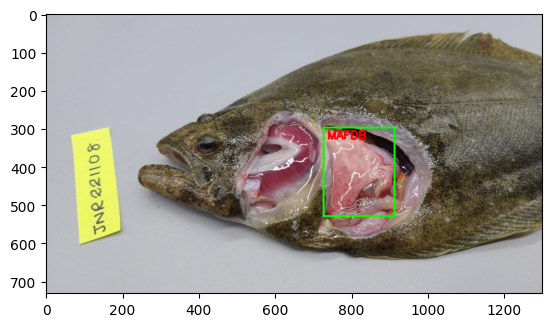

In [36]:
%matplotlib inline
results = []
for im_path in glob.glob("../datasets/halibut/4classes_fish_data/data/yolov8/test/images/*.jpg")[0:10]:
    result = predict(im_path=im_path, im_show=True, classes=classes, details=details)
    results.append(result)

In [37]:
# 예측된 결과의 dictionary
results

[[{'im_path': '../datasets/halibut/4classes_fish_data/data/yolov8/test/images/AMA2221019_02_JPG.rf.10078aa2d64d346f04e32ec25090b38c.jpg',
   'code': 'POOUN',
   'xyxy': (629, 241, 827, 312),
   'details': '정상 외형'}],
 [{'im_path': '../datasets/halibut/4classes_fish_data/data/yolov8/test/images/JHN221001_16_JPG.rf.d8a55835bc25ba59a19a3f09b106e108.jpg',
   'code': 'MAOUY',
   'xyxy': (608, 123, 856, 273),
   'details': '스쿠티카병 질병 외형'},
  {'im_path': '../datasets/halibut/4classes_fish_data/data/yolov8/test/images/JHN221001_16_JPG.rf.d8a55835bc25ba59a19a3f09b106e108.jpg',
   'code': 'VISPE',
   'xyxy': (570, 169, 832, 436),
   'details': '비브리오증 비장 비대'}],
 [{'im_path': '../datasets/halibut/4classes_fish_data/data/yolov8/test/images/JHN221206_04_jpg.rf.da0b2374380c08aa623568aa22c29d35.jpg',
   'code': 'MAFAB',
   'xyxy': (228, 59, 1300, 731),
   'details': '스쿠티카병 뒷 지느러미 기부괴사'}],
 [{'im_path': '../datasets/halibut/4classes_fish_data/data/yolov8/test/images/JDS221016_15_jpg.rf.4255ff14eeec4d486d